# Modelo de un ciclo con hibridación renovable para el almacenamiento y distribución estable de un gasto de aire a muy elevadas temperatures

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')

import csv
import numpy as np
import scipy as sp
import math

import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import odeint, solve_ivp, cumtrapz, RK45
from scipy import signal, fftpack

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 3


### Temporal variables

In [3]:
tf = 24*3600
dt = 3.6
t = np.arange(0, tf + dt, dt)/3600
Nt = len(t)

### DNI

In [4]:
DNI_june = np.loadtxt('./SalamancaJune/Salamanca_June_DNI.csv', delimiter=";", dtype=float)
DNI_march = np.loadtxt('./SalamancaMarch/Salamanca_March_DNI.csv', delimiter=";", dtype=float)
DNI_dec = np.loadtxt('./SalamancaDec/Salamanca_Dec_DNI.csv', delimiter=";", dtype=float)

# Interpolacion
# DNI en kW/m^2
DNI_june = 1e-3*np.interp(t, DNI_june[:,0], DNI_june[:,1])/0.1
DNI_march = 1e-3*np.interp(t, DNI_march[:,0], DNI_march[:,1])/0.1
DNI_dec = 1e-3*np.interp(t, DNI_dec[:,0], DNI_dec[:,1])/0.1

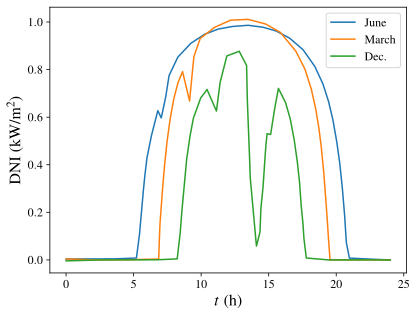

In [5]:
plt.plot(t, DNI_june, t, DNI_march, t, DNI_dec)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'DNI (kW/m$^2$)')
plt.legend(['June', 'March', 'Dec.'])
plt.show()

### Thermal efficiency

In [6]:
etaTh_june = np.loadtxt('./SalamancaJune/Salamanca_June_etaTh.csv', delimiter=";", dtype=float)
etaTh_march = np.loadtxt('./SalamancaMarch/Salamanca_March_etaTh.csv', delimiter=";", dtype=float)
etaTh_dec = np.loadtxt('./SalamancaDec/Salamanca_Dec_etaTh.csv', delimiter=";", dtype=float)

# Interpolacion
etaTh_june = np.interp(t, etaTh_june[:,0], etaTh_june[:,1])
etaTh_march = np.interp(t, etaTh_march[:,0], etaTh_march[:,1])
etaTh_dec = np.interp(t, etaTh_dec[:,0], etaTh_dec[:,1])

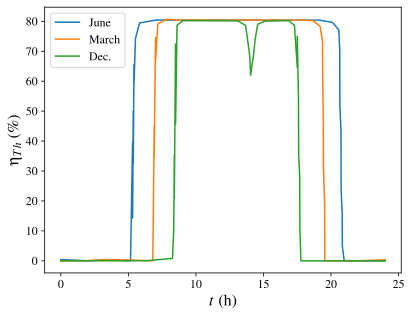

In [7]:
plt.plot(t, etaTh_june, t, etaTh_march, t, etaTh_dec)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$\eta_{Th}$ (\%)')
plt.legend(['June', 'March', 'Dec.'])
plt.show()

### Optical efficiency

In [8]:
etaOpt_june = np.loadtxt('./SalamancaJune/Salamanca_June_etaOpt.csv', delimiter=";", dtype=float)
etaOpt_march = np.loadtxt('./SalamancaMarch/Salamanca_March_etaOpt.csv', delimiter=";", dtype=float)
etaOpt_dec = np.loadtxt('./SalamancaDec/Salamanca_Dec_etaOpt.csv', delimiter=";", dtype=float)

# Interpolacion
etaOpt_june = np.interp(t, etaOpt_june[:,0], etaOpt_june[:,1])
etaOpt_march = np.interp(t, etaOpt_march[:,0], etaOpt_march[:,1])
etaOpt_dec = np.interp(t, etaOpt_dec[:,0], etaOpt_dec[:,1])

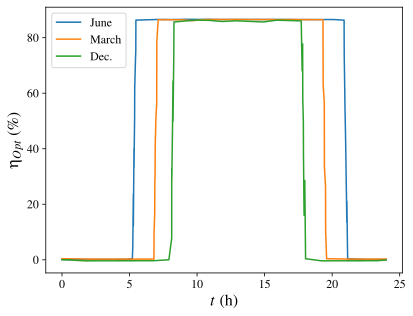

In [9]:
plt.plot(t, etaOpt_june, t, etaOpt_march, t, etaOpt_dec)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$\eta_{Opt}$ (\%)')
plt.legend(['June', 'March', 'Dec.'])
plt.show()

### Ambient temperature

In [10]:
Tamb_june = np.loadtxt('./SalamancaJune/Salamanca_June_Tamb.csv', delimiter=";", dtype=float)
Tamb_march = np.loadtxt('./SalamancaMarch/Salamanca_March_Tamb.csv', delimiter=";", dtype=float)
Tamb_dec = np.loadtxt('./SalamancaDec/Salamanca_Dec_Tamb.csv', delimiter=";", dtype=float)

# Interpolacion
Tamb_june = np.interp(t, Tamb_june[:,0], Tamb_june[:,1])
Tamb_march = np.interp(t, Tamb_march[:,0], Tamb_march[:,1])
Tamb_dec = np.interp(t, Tamb_dec[:,0], Tamb_dec[:,1])

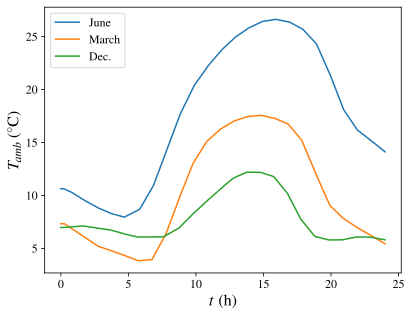

In [11]:
plt.plot(t, Tamb_june, t, Tamb_march, t, Tamb_dec)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$T_{amb}$ ($^\circ$C)')
plt.legend(['June', 'March', 'Dec.'])
plt.show()

### Absorbed heat flux

In [12]:
Qr_june = DNI_june*etaOpt_june/100*etaTh_june/100
Qr_march = DNI_march*etaOpt_march/100*etaTh_march/100
Qr_dec = DNI_dec*etaOpt_dec/100*etaTh_dec/100

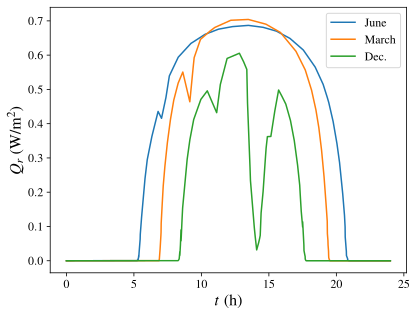

In [13]:
plt.plot(t, Qr_june, t, Qr_march, t, Qr_dec)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$Q_r$ (W/m$^2$)')
plt.legend(['June', 'March', 'Dec.'])
plt.show()

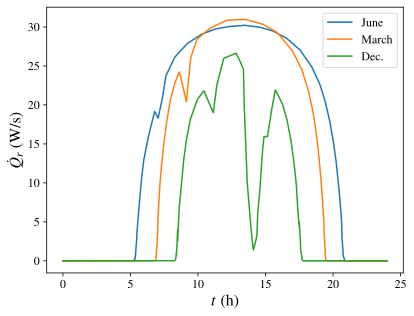

In [14]:
# En m^2
Ad = 44

plt.plot(t, Qr_june*44, t, Qr_march*44, t, Qr_dec*44)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$\dot{Q}_r$ (W/s)')
plt.legend(['June', 'March', 'Dec.'])
plt.show()

In [15]:
Gdem = 0.1 # kg/s
T1 = 300 # K
Cp = 1 # kJ/(kg K)

phi_june = Ad*Qr_june/Gdem/T1/Cp
phi_march = Ad*Qr_march/Gdem/T1/Cp
phi_dec = Ad*Qr_dec/Gdem/T1/Cp

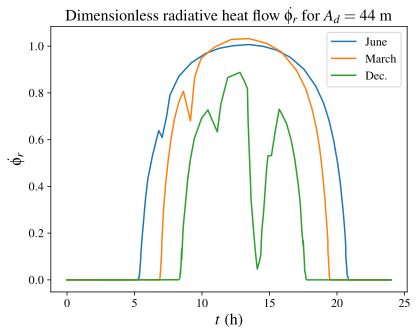

In [16]:
plt.plot(t, phi_june, t, phi_march, t, phi_dec)
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$\dot{\phi}_r$')
plt.legend(['June', 'March', 'Dec.'])
plt.title(r'Dimensionless radiative heat flow $\dot{\phi}_r$ for $A_d = 44$ m')
plt.show()

### Isentropic compression 1-2

In [17]:
# Libro Fernandez-Feria: en la práctica se usan las relaciones isentrópicas
# con un exponente "n" que ajuste a los resultados reales
γ = 1.7
T0 = 300
p0 = 101325
h0 = 300e3
g0 = 1e-3

In [18]:
Tamb = np.concatenate((Tamb_june[:,np.newaxis], Tamb_march[:,np.newaxis], \
                      Tamb_dec[:,np.newaxis]), axis=1)

G1 = Tamb*0 + g0/g0
theta1 = (Tamb + 273)/T0
x1 = Tamb*0 + p0/p0
H1 = Tamb*0 + h0/h0

# The dimensionless power is initialluy constant
xi1 = Tamb*0 + 1
W12 = Tamb*0 + 0.5

H2 = W12/G1 + H1
xi2 = xi1*(W12/G1/H1 + 1)**(γ/(γ - 1))
theta2 = xi2**((γ - 1)/γ)*theta1

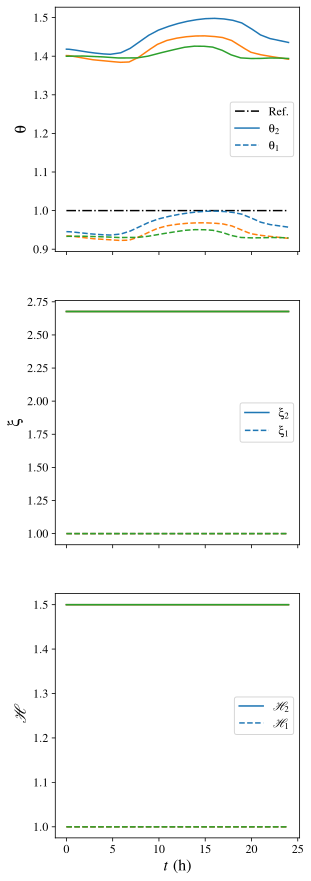

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,15))

ax1.plot(t, t*0 + 1, 'k-.')
ax1.plot(t, theta2)
ax1.set_prop_cycle(None)
ax1.plot(t, theta1, '--')
ax1.set_ylabel(r'$\theta$')
ax1.legend(['Ref.', r'$\theta_2$', '_nolegend_', '_nolegend_', r'$\theta_1$'])
ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')

ax2.plot(t, xi2)
ax2.set_prop_cycle(None)
ax2.plot(t, xi1, '--')
ax2.set_ylabel(r'$\xi$')
ax2.legend([r'$\xi_2$', '_nolegend_', '_nolegend_', r'$\xi_1$'])
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')

ax3.plot(t, H2)
ax3.set_prop_cycle(None)
ax3.plot(t, H1, '--')
plt.xlabel(r'$t$ (h)')
ax3.set_ylabel(r'$\mathcal{H}$')
ax3.legend([r'$\mathcal{H}_2$', '_nolegend_', '_nolegend_', r'$\mathcal{H}_1$'])
ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')

plt.show()

### CSP $-$ SPD 2-3

In [20]:
phir = np.concatenate((phi_june[:,np.newaxis], phi_march[:,np.newaxis],\
                       phi_dec[:,np.newaxis]), axis=1)

H3 = phir + H2
theta3 = phir/G1 + theta2
xi3 = xi2*(theta3/theta2)**(γ/(γ - 1))

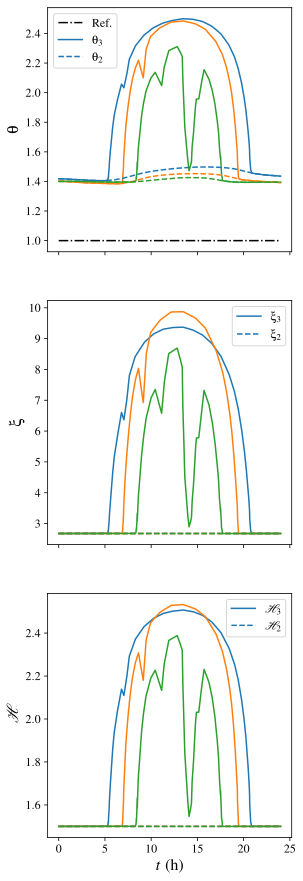

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,15))

ax1.plot(t, t*0 + 1, 'k-.')
ax1.plot(t, theta3)
ax1.set_prop_cycle(None)
ax1.plot(t, theta2, '--')
ax1.set_ylabel(r'$\theta$')
ax1.legend(['Ref.', r'$\theta_3$', '_nolegend_', '_nolegend_', r'$\theta_2$'])
ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')

ax2.plot(t, xi3)
ax2.set_prop_cycle(None)
ax2.plot(t, xi2, '--')
plt.xlabel(r'$t$ (h)')
ax2.set_ylabel(r'$\xi$')
ax2.legend([r'$\xi_3$', '_nolegend_', '_nolegend_', r'$\xi_2$'])
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')

ax3.plot(t, H3)
ax3.set_prop_cycle(None)
ax3.plot(t, H2, '--')
plt.xlabel(r'$t$ (h)')
ax3.set_ylabel(r'$\mathcal{H}$')
ax3.legend([r'$\mathcal{H}_3$', '_nolegend_', '_nolegend_', r'$\mathcal{H}_2$'])
ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')

plt.show()

### Isentropic compression 3-4

In [22]:
# The dimensionless power is initialluy constant
W34 = W12 

xi4 = xi3*(W34/G1/H3 + 1)**(γ/(γ - 1))
theta4 = (xi4/xi3)**((γ - 1)/γ)*theta3
H4 = W34/G1 + H3

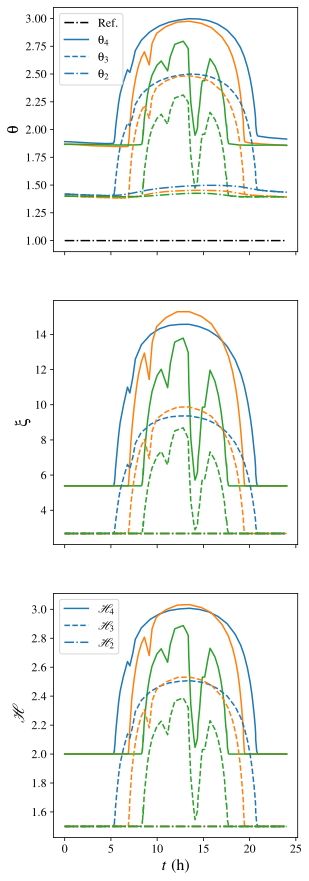

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,15))

ax1.plot(t, t*0 + 1, 'k-.')
ax1.plot(t, theta4)
ax1.set_prop_cycle(None)
ax1.plot(t, theta3, '--')
ax1.set_prop_cycle(None)
ax1.plot(t, theta2, '-.')
ax1.set_ylabel(r'$\theta$')
ax1.legend(['Ref.', r'$\theta_4$', '_nolegend_', '_nolegend_', r'$\theta_3$',\
           '_nolegend_', '_nolegend_', r'$\theta_2$'])
ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')

ax2.plot(t, xi4)
ax2.set_prop_cycle(None)
ax2.plot(t, xi3, '--')
ax2.set_prop_cycle(None)
ax2.plot(t, xi2, '-.')
plt.xlabel(r'$t$ (h)')
ax2.set_ylabel(r'$\xi$')
plt.legend([r'$\xi_4$', '_nolegend_', '_nolegend_', r'$\xi_3$', \
           '_nolegend_', '_nolegend_', r'$\xi_2$'])
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')

ax3.plot(t, H4)
ax3.set_prop_cycle(None)
ax3.plot(t, H3, '--')
ax3.set_prop_cycle(None)
ax3.plot(t, H2, '-.')
plt.xlabel(r'$t$ (h)')
ax3.set_ylabel(r'$\mathcal{H}$')
ax3.legend([r'$\mathcal{H}_4$', '_nolegend_', '_nolegend_', r'$\mathcal{H}_3$', \
           '_nolegend_', '_nolegend_', r'$\mathcal{H}_2$'])
ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')

plt.show()

### Thermal Energy Storage

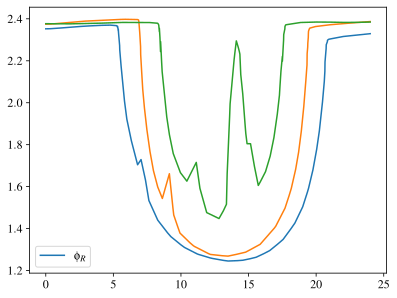

In [24]:
thetaMax = (1000 + 273)/T1

phiR = (thetaMax - theta4)*G1

fig, ax = plt.subplots()

plt.plot(t, phiR)

plt.legend([r'$\phi_R$', '_nolegend_', '_nolegend_', r'$1-\theta_4/\theta_{max}$', \
           '_nolegend_', '_nolegend_', r'$\xi_2$'])

plt.show()

# Thermal buffer solution with ivp_solve and RK45 (to compare with)

In [25]:
k = 0
V = 1
Rair = 287.05
mStar = V*p0/Rair/T0
tc = mStar/G1[0,0]
dtt = (t[1] - t[0])/tc

In [151]:
gf = 0.75
interp = interp1d(t, (G1[:,k], H4[:,k], Cp*Tamb[:,k]/T0))

def TESheating(t, y, Gin, Gout, Hin, Hout, thetaMax, γ):

    Gin, Hin, Hout = interp(t)
        
    # Utilizo una funcion logistica para hacer una transición suave hacia phiR = 0
    # Hay que evitar phiR < 0 (no tiene sentido físico)

    alpha = 1
    sigma = 1/(1 + math.exp(-alpha*((thetaMax - y[1])*Gin/dt)))
    phiR = (thetaMax - y[1])*Gin/dtt*sigma
    
    dxidt = (γ - 1)*(Gin*Hin - Gout*Hout + phiR)
    dthetadt = (dxidt*y[1] - (Gin - Gout)*y[1]**2)/y[0]
    
    return [dxidt, dthetadt]

In [27]:
y0 = [xi4[0,0], theta4[0,0]]
p = (G1[:,k], gf*G1[0,0], H4[:,k], H1[:,k], thetaMax, γ)
sol = solve_ivp(TESheating, (t[0], t[-1])/tc, y0, args=p, method='RK45', t_eval=t/tc)

xi5 = sol.y[0,:]
theta5 = sol.y[1,:]

def exp(a):
    return math.exp(a)

vexp = np.vectorize(exp)

# phiR = 0.5*((thetaMax - theta5)*G1[:,k]/dtt + np.abs((thetaMax - theta5)*G1[:,k]/dtt))
# alpha = 1/dtt  # Ajusta este valor según la suavidad deseada
# phiR = 0.5*((thetaMax - theta5)*G1[:,k]/dtt +\
#             (1.0 - vtanh(alpha*((thetaMax - theta5)*G1[:,k]/dtt)))*(thetaMax -theta5)*G1[:,k]/dtt)

alpha = 1
sigma = 1/(1 + vexp(-alpha*((thetaMax - theta5)*G1[:,k]/dtt)))
phiR = (thetaMax - theta5)*G1[:,k]/dtt*sigma

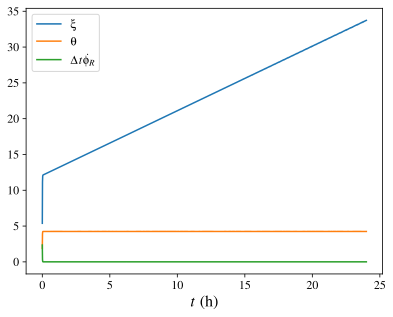

In [28]:
plt.plot(t, xi5, t, theta5, t, phiR*dtt)
plt.xlabel('$t$ (h)')
plt.legend([r'$\xi$', r'$\theta$', '$\Delta\, t \dot{\phi}_R$'])
plt.show()

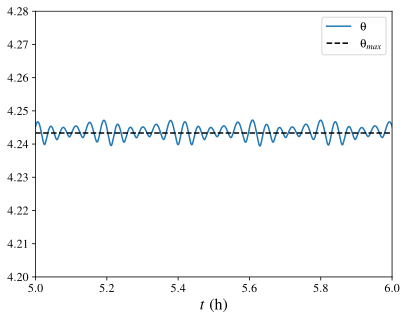

In [29]:
plt.plot(t, theta5, t, theta5*0 + thetaMax, 'k--')
plt.xlim([5, 6])
plt.ylim([4.20, 4.28])
plt.xlabel('$t$ (h)')
plt.legend([r'$\theta$', r'$\theta_{max}$'])
plt.show()

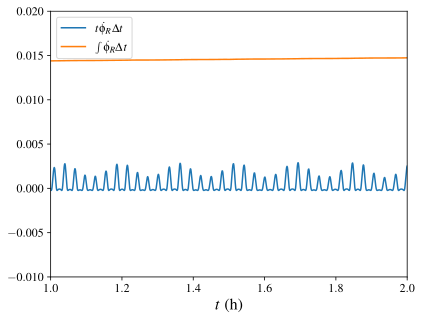

In [31]:
plt.plot(t, phiR*dtt)
plt.plot(t, cumtrapz(phiR*dtt, t/tc, initial=phiR[0]*dtt))
plt.xlim([1, 2])
plt.ylim([-0.01, 0.02])
plt.legend([r'$t \dot{\phi}_R \, \Delta t$', r'$\int{\dot{\phi}_R \Delta \, t}$'])
plt.xlabel('$t$ (h)')
plt.show()

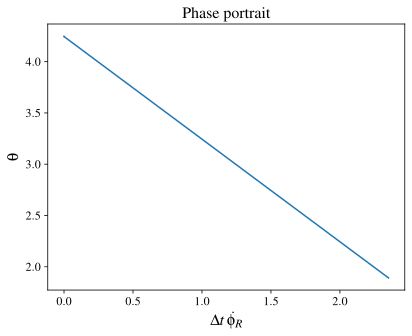

In [32]:
plt.plot(phiR*dtt, theta5)
plt.xlabel('$\Delta t\,\dot{\phi}_R$')
plt.ylabel(r'$\theta$')
plt.title('Phase portrait')
plt.show()

# Numerical solution of thermal buffer - thermocline tank

## Thermal buffer

In [139]:
k = 0 # number to switch season

V = 1
Rair = 287.05
mStar = V*p0/Rair/T0
tc = mStar/G1[0,0]

In [179]:
def TESheatingBis(xi, theta, Gin, Gout, Hin, Hout, thetaMax, γ):

#     alpha = 1
#     sigma = 1/(1 + math.exp(-alpha*((thetaMax - theta)*Gin/dt)))
#     phiR = (thetaMax - theta)*Gin/dtt*sigma

    phiR = (thetaMax - theta)*Gin/dtt
    
    dxidt = (γ - 1)*(Gin*Hin - Gout*Hout + phiR)
    dthetadt = (dxidt*theta - (Gin - Gout)*theta**2)/xi
    
    return [dxidt, dthetadt]

## Thermocline tank

In [180]:
R = 1.5
H = 12
eps = 0.22

dx = 2.2e-2

xf = H
x = np.arange(0, xf + dx, dx)
dx = x[1] - x[0]

Nx = len(x) - 1

In [181]:
rhof = 2090 - 0.636*T0
muf = 0.0021 #(22.174 - 0.12*Tavg + 2.281e-4*Tavg**2 - 1.474e-7*Tavg**3)/1000
cpf = 1443 + 0.172*T0
kf = 0.443 + 0.00019*T0

d = 0.015
mDot = 7.0
u = mDot/(rhof*eps*np.pi*R**2)

rhos = 2500
cps = 830
ks = 5.69

In [182]:
s0h = np.loadtxt('./Sandia_0h.csv', delimiter=";", dtype=float)
T0p = s0h[:,1]
x0p = s0h[:,0]

f = interp1d(x0p, T0p, fill_value="extrapolate")
T00 = f(x) + 273

In [183]:
Tin = theta4[0,k]*T0 #Tamb[:,k]

Tf = np.zeros((Nt, Nx+1))
Ts = np.zeros((Nt, Nx+1))

# BCs
Tf[:,0] = Tin
bc1 = np.zeros(Nx)

# ICs
Tf[0,:] = T00
Ts[0,:] = T00

In [184]:
alpha = eps*rhof*cpf
beta = eps*kf
gamma = (1-eps)*rhos*cps
betas = ks*(1 - eps)

Rep = rhof*d*u/muf
Pr = cpf*muf/kf
Nu = 0.664*Rep**0.5*Pr**0.5
a = Nu*kf/d
#h = 6*(1-eps)*beta*(2 + 1.1*Rep**(0.6)*Pr**(1/3))/(d**2)

h = a*6*(1-eps)/d

p = dt*u/dx
q = 2*beta/alpha*0.5*dt/(dx**2)
r = h*dt/alpha

rs = dt*h/gamma
qs = 2*betas*0.5*dt/(gamma*dx**2)

In [185]:
diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]
offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q - p

A = sp.sparse.csr_matrix(A)

In [186]:
diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]
offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)

In [240]:
xi5 = xi4*0
xi5[0,k] = xi4[0,k]

theta5 = theta4*0
theta6 = theta5*0

theta5[0,k] = theta4[0,k]
theta6[0,k] = theta5[0,k]

dtt = (t[1] - t[0])/tc

In [241]:
gf = np.zeros_like(t) + 0.75

In [ ]:
for i in range(1,len(t)):
    
    # ODE solution -- THERMAL BUFFER
    
    Cp = 1.0575e3 - 4.4890e-1*theta5[i-1,k]*T0 + 1.1407e-3*(theta5[i-1,k]*T0)**2 - \
        8.0e-7*(theta5[i-1,k]*T0)**3 + 1.9327e-10*(theta5[i-1,k]*T0)**4
    Hout = Tf[i-1,0]*Cp/h0
    
    # Function call:
    # TESheatingBis(t, xi, theta, Gin, Gout, Hin, Hout, thetaMax, γ):
    
    [k1xi, k1theta] = TESheatingBis(xi5[i-1,k], theta5[i-1,k], G1[i-1,k], gf[i-1]*G1[0,k], \
                       H4[i-1,k], Hout, thetaMax, γ)
    [k2xi, k2theta]  = TESheatingBis(xi5[i-1,k] + k1xi*0.5*dtt, theta5[i-1,k] + k1theta*0.5*dtt, \
                                     G1[i-1,k], gf[i-1]*G1[0,k], \
                       H4[i-1,k], Hout, thetaMax, γ)
    [k3xi, k3theta]  = TESheatingBis(xi5[i-1,k] + k2xi*0.5*dtt, theta5[i-1,k] + k2theta*0.5*dtt, \
                                     G1[i,k], gf[i-1]*G1[0,k], \
                       H4[i-1,k], Hout, thetaMax, γ)
    [k4xi, k4theta]  = TESheatingBis(xi5[i-1,k] + k3xi*dtt, theta5[i-1,k] + k3theta*dtt, \
                                     G1[i,k], gf[i-1]*G1[0,k], \
                       H4[i-1,k], Hout, thetaMax, γ)
    
    xi5[i,k] = xi5[i-1,k] + 1/6*dtt*(k1xi + 2*k2xi + 2*k3xi + k4xi)
    theta5[i,k] = theta5[i-1,k] + 1/6*dtt*(k1theta + 2*k2theta + 2*k3theta + k4theta)
    
    # --------------------------------------------------------------------------------------------------- #
    # --------------------------------------------------------------------------------------------------- #
    # --------------------------------------------------------------------------------------------------- #
    
    # Thermocline TANK -- fluid properties changing with temperature
    
    rhof = 2090 - 0.636*theta5[i-1,k]*T0
    muf = 22.174/1000
    cpf = 1443 + 0.172*theta5[i-1,k]*T0
    kf = 0.443 + 0.00019*theta5[i-1,k]*T0
    
    alpha = eps*rhof*cpf
    beta = eps*kf
    gamma = (1-eps)*rhos*cps
    betas = ks*(1 - eps)

    Rep = rhof*d*u/muf
    Pr = cpf*muf/kf
    Nu = 0.664*Rep**0.5*Pr**0.5
    a = Nu*kf/d
    h = 6*(1-eps)*beta*(2 + 1.1*Rep**(0.6)*Pr**(1/3))/(d**2)

    p = dt*u/dx
    q = 2*beta/alpha*0.5*dt/(dx**2)
    r = h*dt/alpha

    rs = dt*h/gamma
    qs = 2*betas*0.5*dt/(gamma*dx**2)
    
    diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]
    offsets = [0, 1, -1]
    A.setdiag(diagonals[0], offsets[0])
    A.setdiag(diagonals[1], offsets[1])
    A.setdiag(diagonals[2], offsets[2])
    A[-1,-2] = -2*q - p
    
    diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]
    offsets = [0, 1, -1]
    As.setdiag(diagonals[0], offsets[0])
    As.setdiag(diagonals[1], offsets[1])
    As.setdiag(diagonals[2], offsets[2])
    As[-1,-2] = -2*qs
    As[0,1] = -2*qs  
        
    # PDE solution -- TANK
    
    bc1[0] = theta5[i-1,k]*T0

    Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*Tf[i-1,:])
    Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 + \
                r*Ts[i-1,1:])
    
    theta6[i,k] = Tf[i,-1]/T0
        

In [ ]:
plt.plot(t, xi5[:,k], t, theta5[:,k], t, phiR*dtt)
plt.xlabel(r'$t$ (h)')
plt.legend([r'$\xi$', r'$\theta$', '$\dot{\phi}_R$'])
plt.show()

In [ ]:
plt.plot(t, theta5, t, theta5*0 + thetaMax, 'k--')
plt.xlim([0, 24])
plt.ylim([4.20, 4.30])
plt.xlabel(r'$t$ (h)')
plt.legend([r'$\theta$', r'$\theta_{max}$'])
plt.show()

In [ ]:
fig, ax = plt.subplots()

cs1 = ax.contourf(x, t, Tf - 273, 16)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T_f$ ($^\circ$ C)', fontsize=16)
ax.set_ylabel(r'$t$ (h)')
ax.set_xlabel(r'$H$ (m)')
ax.set_box_aspect(1)

plt.show()

In [ ]:
plt.plot(x, Tf[0,:] - 273, x, Tf[2000,:] - 273, x, Tf[4000,:] - 273, x, Tf[6000,:] - 273)
plt.xlabel(r'$H$ (m)')
plt.ylabel(r'$T$ ($^\circ$ C)')
plt.legend([r'$t_0$', r'$t_1$', '$t_2$', '$t_3$', '$t_4$'])
plt.show()

In [ ]:
plt.plot(t, theta6[:,k])
plt.xlabel(r'$t$ (h)')
plt.ylabel(r'$\theta_6$')
plt.show()